## init

In [24]:
import sys 
sys.path.append('pyfiles/')

import parametrics as par
import complex as cplx
import matrix as mat
from pyfiles.matrix import bdmatrix
import vineyard as vin 
import input as inp 
import plot as ourplot


# so we don't have to reboot kernel every time we modify classes.py
%load_ext autoreload
%autoreload 2

# math stuff
import numpy as np
import math
# visualization
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.ndimage import gaussian_filter1d
from scipy.spatial import distance
from scipy.stats import qmc
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline

import csv
import string

# for polygon grid
from matplotlib.path import Path as mplPath

######## NOTE: from this point on, order is important. 
# it would be good to make the code more robust, but right
# now, there are ordered dependencies between functions.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## this is the new, streamlined thing

<module 'matplotlib.pyplot' from '/Users/elizastep/Desktop/coding/medial_ax/venv/lib/python3.9/site-packages/matplotlib/pyplot.py'>

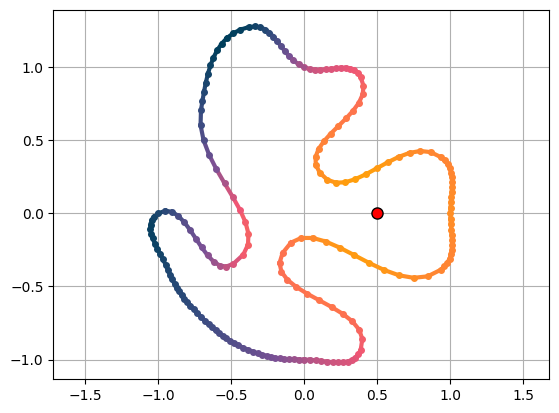

In [33]:
# read in .obj file
our_complex = inp.read_obj("input/blob.obj")

# set the key point from which we measure radial dist
our_complex.key_point = (.5, 0)
# sort
distlist = cplx.augment_with_radialdist(our_complex)
our_complex.sort_by_dist(distlist)

# plot the complex with a heatmap from the key point
ourplot.plot_complex(our_complex)
